## Introduction

Wind turbines generate power by conversion of kinetik energy of air particles (wind flow) into mechanical energy. There are some degrees of uncertainties in the speed and direction of wind flows into the sweep area of wind turbines. This uncertainty would result in some fluctuation in power generation that makes complex operating conditions for the turbines. For better maintenance, there are some power curves descrbining the relationship between output power and hub height wind speed. These curves would help the operators in energy forecasting, performance monitoring, and so on. 

## Data

In wind power systems, Supervisory Control and Data Acquisition (SCADA) systems measure some specific parameters for operation condition monitoring of wind turbines. In this notebook, I built a model on a dataset which was taken from a wind turbine's SCADA system in Turkey.

The dataset link is here: 


#### The values of the parameters has been recorded in a csv file format. The features are:

#### Date/Time 
The data values are recorded in 10 minutes intervals

#### LV ActivePower (kW): 
The power generated by the turbine for that moment

#### Wind Speed (m/s):
The wind speed at the hub height of the turbine (the wind speed that turbine use for electricity generation)

#### Theoretical_Power_Curve (KW): 
The theoretical power values that the turbine generates with that wind speed which is given by the turbine manufacturer

#### Wind Direction (°): 
The wind direction at the hub height of the turbine (wind turbines turn to this direction automaticly)


## The Scope of this model:
The goal is to build classification models to indentify the status of the wind turbines based on the differnce between The real power (LV Active Power (KW)) and the theoretical power curve (KW). A threshold is considered for this difference to lable the data rows as "ok" or not "ok status.
The considered threshold in this model is 10%.

# Data Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../input/wind-turbine-scada-dataset/T1.csv'); df.describe()

LV ActivePower (kW)  Wind Speed (m/s)  Theoretical_Power_Curve (KWh)  \
count         50530.000000      50530.000000                   50530.000000   
mean           1307.684332          7.557952                    1492.175463   
std            1312.459242          4.227166                    1368.018238   
min              -2.471405          0.000000                       0.000000   
25%              50.677890          4.201395                     161.328167   
50%             825.838074          7.104594                    1063.776283   
75%            2482.507568         10.300020                    2964.972462   
max            3618.732910         25.206011                    3600.000000   

       Wind Direction (°)  
count        50530.000000  
mean           123.687559  
std             93.443736  
min              0.000000  
25%             49.315437  
50%             73.712978  
75%            201.696720  
max            359.997589

# Exploratory Data Analysis

### Convert the Date/Time column into datetime format

In [3]:
from datetime import datetime

# Make a copy of the DataFrame
df1 = df.copy()

# Define the time format
time_format = "%d %m %Y %H:%M"

# Convert the "Date/Time" column to string and then apply datetime conversion
df1["Date/Time"] = df1["Date/Time"].astype(str).apply(lambda x: datetime.strptime(x, time_format))

# Print the modified DataFrame
df1.set_index('Date/Time',inplace=True)

df1

LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336   
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  
Date/Time                                                               
2018-01-01 00:00:00                     416.328908          259.994904  
2018-01-01 00:10:00                     519.917511          268.641113  
2018-01-01 00:20:00                     390.900016          272.564789  
2018-01-01 00:30:00                     516.127569          271.258087  
2018-01-01 00:40:00                     491.702972          265.674286  
...                                            ...                 ...  
2018-12-31 23:10:00                    3397.190793           80.502724  
2018-12-31 23:20:00                    1173.055771           84.062599  
2018-12-31 23:30:00                    1788.284755           84.742500  
2018-12-31 23:40:00                    2418.382503           84.297913  
2018-12-31 23:50:00                    2779.184096           82.274620  

[50530 rows x 4 columns]

### Plotting Distribution of dataset variables

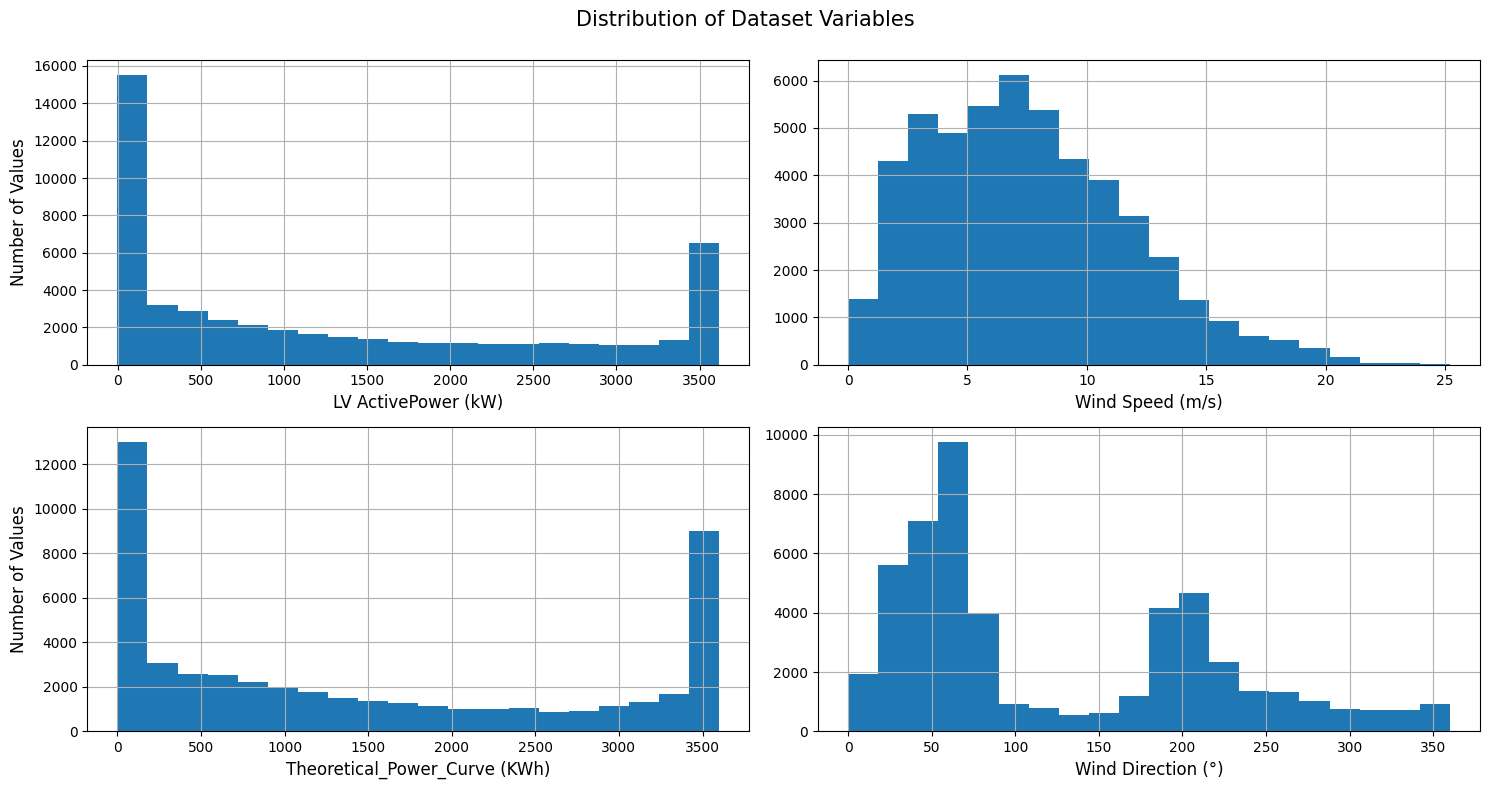

In [4]:
plt.figure(figsize=(15,8))
plt.suptitle('Distribution of Dataset Variables', fontsize=15)  

for i in range(1, len(df.columns)):
    plt.subplot(2, 2, i)
    fig = df[df.columns[i]].hist(bins=20)
    fig.set_xlabel(df.columns[i], fontsize=12)
    if (i%2 != 0)==True:
        fig.set_ylabel('Number of Values', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Plotting LV Active Power (KW) and Theoretical power curves vs. wind speed for different wind directions in 5 degrees interval

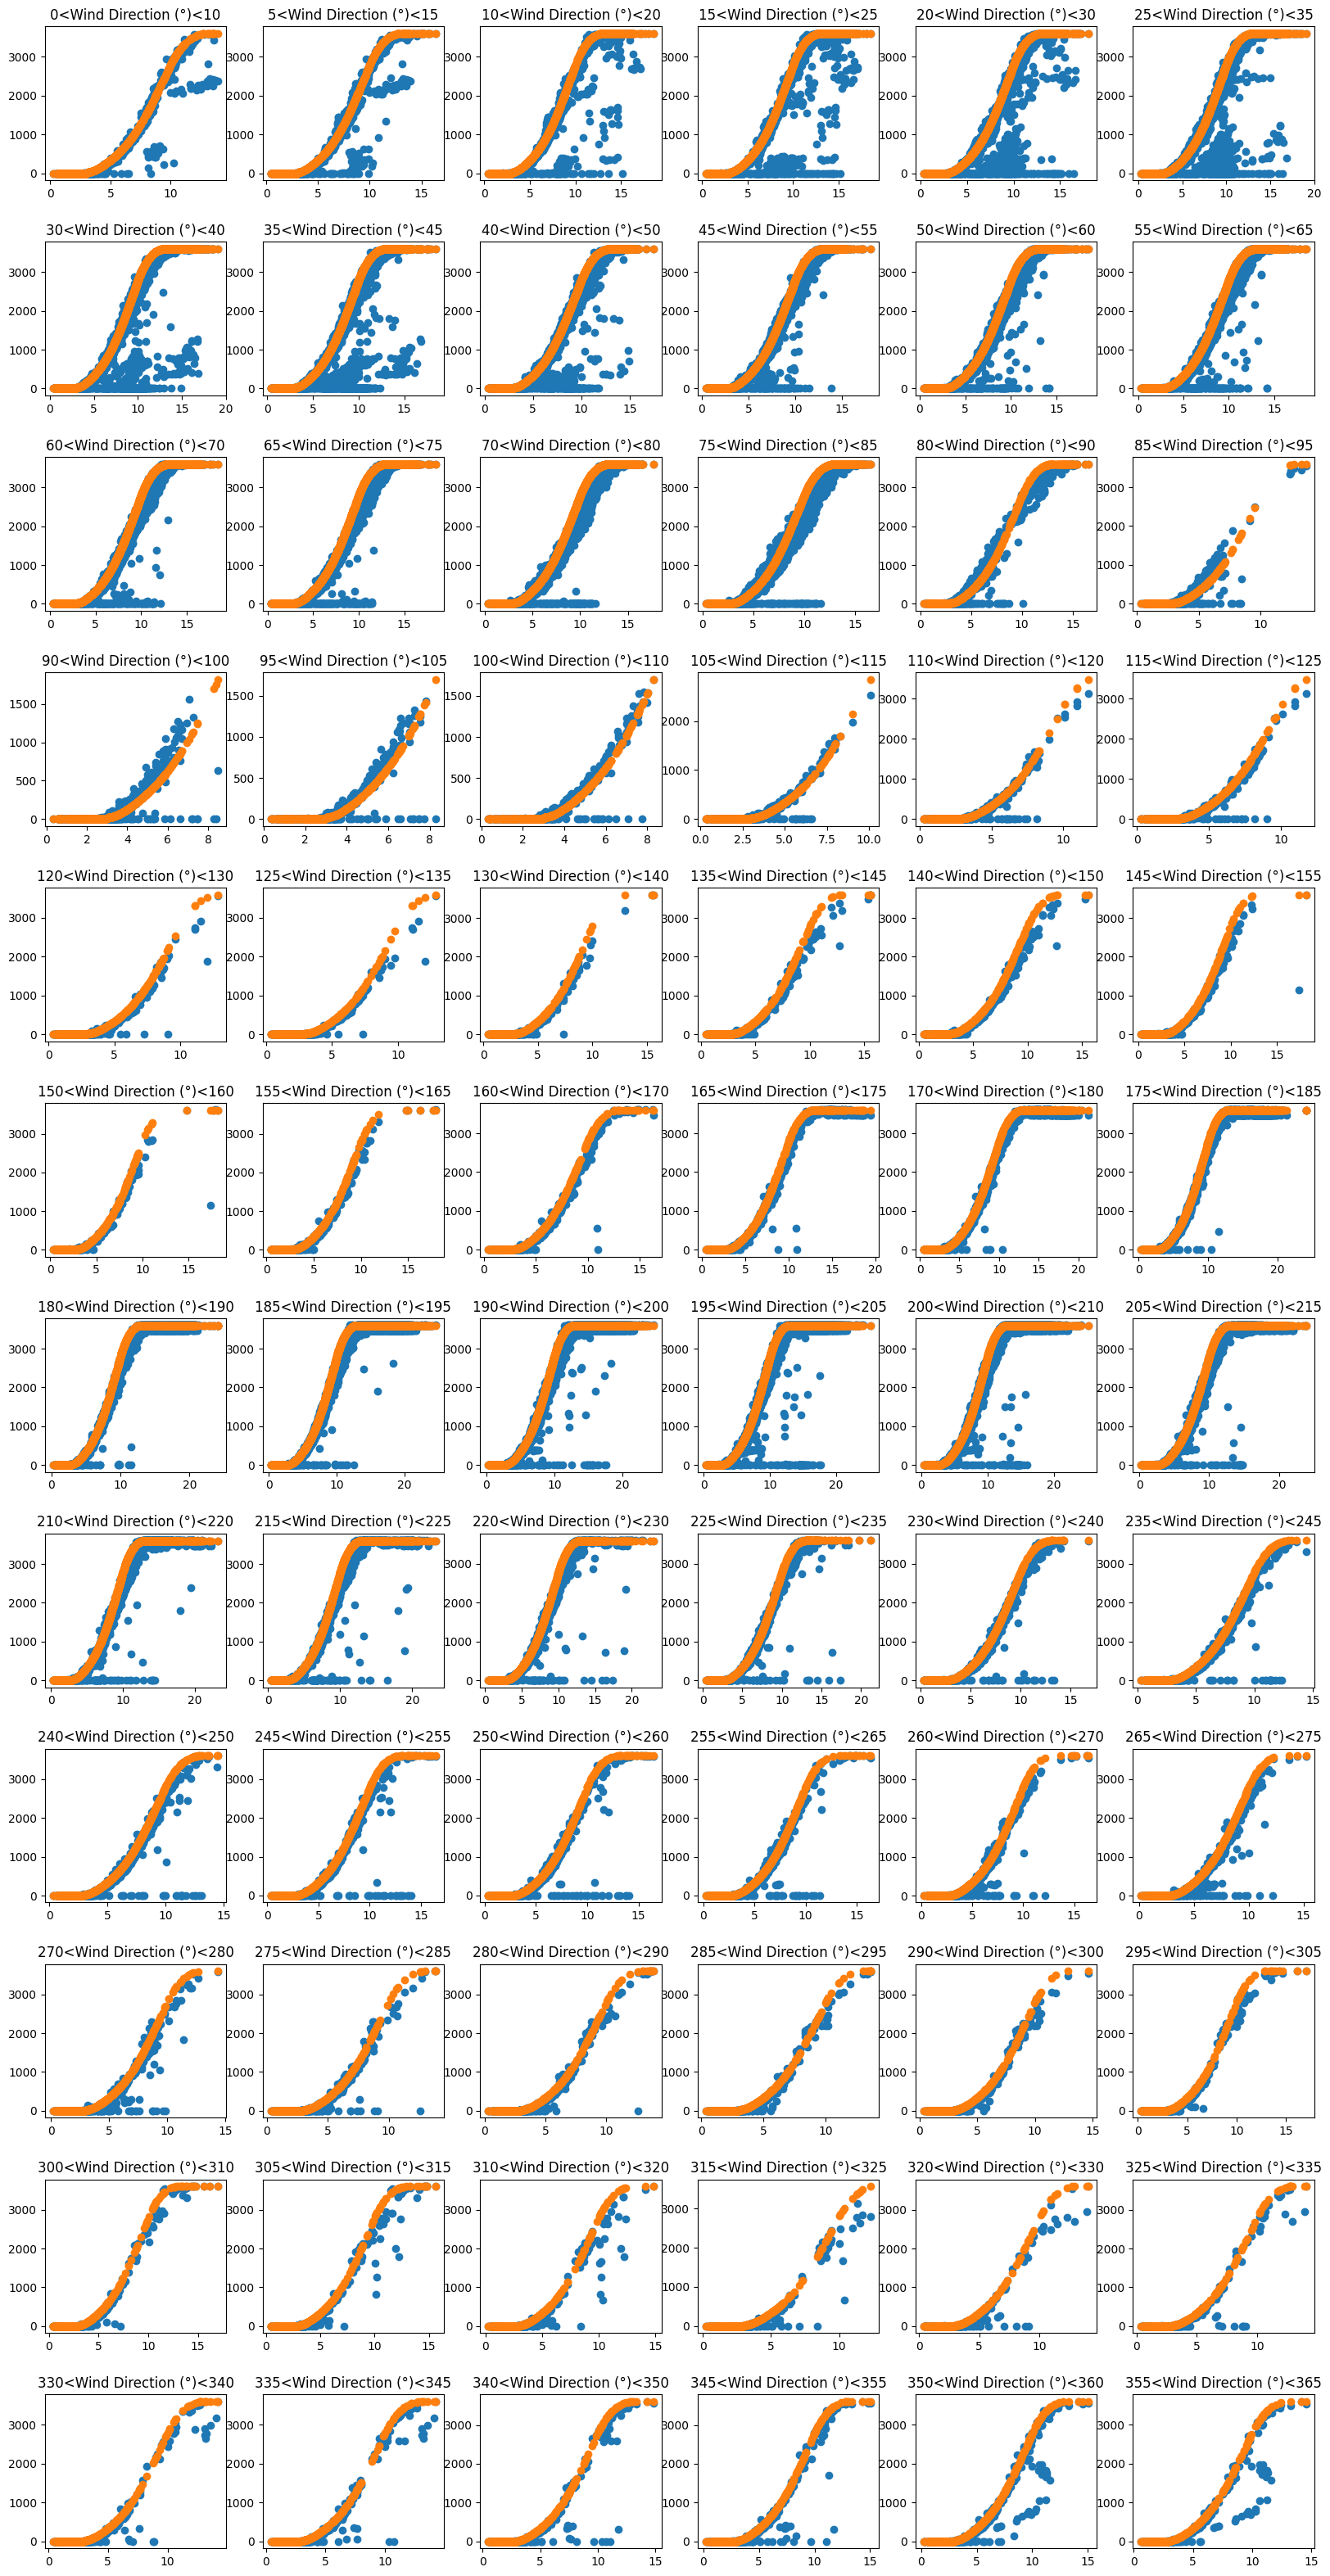

In [5]:
n = 0
plt.figure(figsize=(20,40))
for i in range(0,360,5):
    condition = (df1['Wind Direction (°)']>i) & (df1['Wind Direction (°)']<i+10)
    n += 1; fig = plt.subplot(12, 6, n)  # Subplot indexing starts from 1
    fig.scatter(df1.loc[condition,'Wind Speed (m/s)'],df1.loc[condition,'LV ActivePower (kW)'])
    fig.scatter(df1.loc[condition,'Wind Speed (m/s)'],df1.loc[condition,'Theoretical_Power_Curve (KWh)'])
    fig.set_title(f'{i}<Wind Direction (°)<{(i+10)}')
    plt.subplots_adjust(hspace=0.4)
plt.show()

### Defining Power deficit values in percentage

In [6]:
# Defining Power deficit values in percentage

df2 = df1.copy()

power_deficit_percentage = 100*(df2['LV ActivePower (kW)']-df2['Theoretical_Power_Curve (KWh)'])/df2['Theoretical_Power_Curve (KWh)']
df2.insert(4,'power_deficit_percentage',power_deficit_percentage)

# considering 0 for zero values of theoritcal power
df2.loc[df2['Theoretical_Power_Curve (KWh)']==0,'power_deficit_percentage'] = 0

# Defining the status label of the turbines wih two numeric values: 1 for "ok"; 0 for "not ok"
threshold = 10

condition = (df2["power_deficit_percentage"]<threshold)&(df2["power_deficit_percentage"]>-threshold)
df2.loc[condition,"turbine_status"] = 1 # meaning that the turbine don't work near theoretical power curve
condition = (df2["power_deficit_percentage"]>threshold)|(df2["power_deficit_percentage"]<-threshold)
df2.loc[condition,"turbine_status"] = 0 # meaning that the turbine does work near theoretical power curve

df2

LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336   
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  \
Date/Time                                                                
2018-01-01 00:00:00                     416.328908          259.994904   
2018-01-01 00:10:00                     519.917511          268.641113   
2018-01-01 00:20:00                     390.900016          272.564789   
2018-01-01 00:30:00                     516.127569          271.258087   
2018-01-01 00:40:00                     491.702972          265.674286   
...                                            ...                 ...   
2018-12-31 23:10:00                    3397.190793           80.502724   
2018-12-31 23:20:00                    1173.055771           84.062599   
2018-12-31 23:30:00                    1788.284755           84.742500   
2018-12-31 23:40:00                    2418.382503           84.297913   
2018-12-31 23:50:00                    2779.184096           82.274620   

                     power_deficit_percentage  turbine_status  
Date/Time                                                      
2018-01-01 00:00:00                 -8.714532             1.0  
2018-01-01 00:10:00                -12.722848             0.0  
2018-01-01 00:20:00                -21.622774             0.0  
2018-01-01 00:30:00                -18.693375             0.0  
2018-01-01 00:40:00                -22.585236             0.0  
...                                       ...             ...  
2018-12-31 23:10:00                -12.752002             0.0  
2018-12-31 23:20:00                 43.586782             0.0  
2018-12-31 23:30:00                 23.084812             0.0  
2018-12-31 23:40:00                  4.023829             1.0  
2018-12-31 23:50:00                  1.485399             1.0  

[50530 rows x 6 columns]

# Model

## Library Import

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

## Logistic Regression

In [8]:
from sklearn.linear_model import LogisticRegression

In [9]:
x = df2.drop(columns=["turbine_status"])
y = df2['turbine_status']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=0)

regressor = LogisticRegression()
regressor.fit(x_train, y_train)

result = regressor.score(x_test,y_test)

print(result)

0.9236097367900258


In [10]:
y_pred = regressor.predict(x_test)

print("Mean Absolute Error:        "    , metrics.mean_absolute_error(y_test,y_pred))
print("\nMean Squared Error:         "  , metrics.mean_squared_error(y_test,y_pred))
print("\nRoot Mean Absolute Error:   "  , np.sqrt(metrics.mean_absolute_error(y_test,y_pred)))
print("\nR2 Score:        "             , metrics.r2_score(y_test,y_pred))

Mean Absolute Error:         0.07639026320997427

Mean Squared Error:          0.07639026320997427

Root Mean Absolute Error:    0.27638788542549086

R2 Score:         0.6941088175051626


Logistic Regression

 [[4513  374]
 [ 398 4821]]

(turbine_status):1 / (turbine_status):1  =  4513

(turbine_status):2 / (turbine_status):2  =  374

(turbine_status):3 / (turbine_status):3 =  374

(turbine_status):0 / (turbine_status):0 =  4821


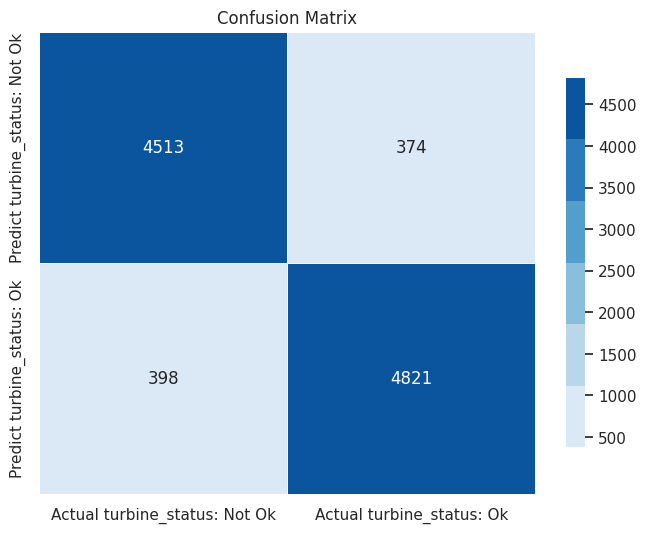

In [11]:
#### Confusion Matrix

cm = confusion_matrix(y_test, y_pred)

print('\033[1mLogistic Regression\033[0m\n\n', cm)

print('\n(turbine_status):1 / (turbine_status):1  = ', cm[0,0])

print('\n(turbine_status):2 / (turbine_status):2  = ', cm[0,1])

print('\n(turbine_status):3 / (turbine_status):3 = ', cm[0,1])

print('\n(turbine_status):0 / (turbine_status):0 = ', cm[1,1])



#### Create graphical confusion matrix
cm_matrix = pd.DataFrame(data=cm, 
 columns=['Actual turbine_status: Not Ok', 'Actual turbine_status: Ok'], 
 index=['Predict turbine_status: Not Ok', 'Predict turbine_status: Ok'])

# Set a custom color palette
colors = sns.color_palette("Blues")

# Create a seaborn heatmap
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.0)  # Adjust the font scale
sns.set_style("whitegrid")  # Use a white grid background

# Plot the heatmap
heatmap = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=colors, linewidths=.5, cbar_kws={"shrink": 0.8})

# Customize labels and title
plt.title('Confusion Matrix')

# Show the plot
plt.show()
plt.rcdefaults()

## SVM

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

In [13]:
X = df2.drop(['turbine_status'], axis=1)
y = df2['turbine_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

print('Train: ',X_train.shape)
print('Test : ',X_test.shape)

cols = X_train.columns
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=[cols])

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=[cols])

X_train.describe()

Train:  (40424, 5)
Test :  (10106, 5)


LV ActivePower (kW) Wind Speed (m/s) Theoretical_Power_Curve (KWh)  \
count        4.042400e+04     4.042400e+04                  4.042400e+04   
mean         4.991939e-17    -2.524093e-16                  9.210479e-17   
std          1.000012e+00     1.000012e+00                  1.000012e+00   
min         -9.984289e-01    -1.789267e+00                 -1.090827e+00   
25%         -9.577492e-01    -7.938223e-01                 -9.728114e-01   
50%         -3.657416e-01    -1.056360e-01                 -3.121210e-01   
75%          8.919475e-01     6.468119e-01                  1.071255e+00   
max          1.763724e+00     4.183070e+00                  1.543179e+00   

      Wind Direction (°) power_deficit_percentage  
count       4.042400e+04             4.042400e+04  
mean        7.241827e-17             2.214733e-17  
std         1.000012e+00             1.000012e+00  
min        -1.322831e+00            -3.304474e+00  
25%        -7.962155e-01            -7.820913e-02  
50%        -5.350526e-01             2.637221e-01  
75%         8.341658e-01             5.424654e-01  
max         2.525277e+00             1.852739e+01

### Iterativing between four kernels for SVM classification

kernel = linear
Model accuracy score with linear kernel: 0.9439936671284386
Confusion matrix

 [[4535  352]
 [ 214 5005]]

(turbine_status):1 / (turbine_status):1  =  4535

(turbine_status):2 / (turbine_status):2  =  352

(turbine_status):3 / (turbine_status):3 =  352

(turbine_status):0 / (turbine_status):0 =  5005


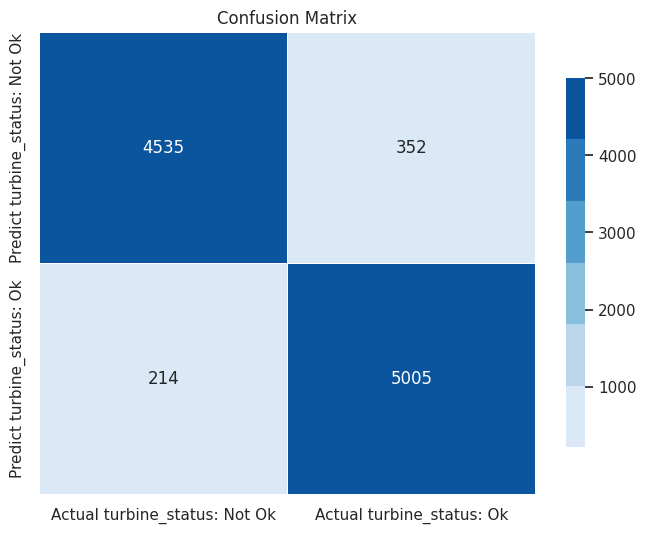

kernel = poly
Model accuracy score with poly kernel: 0.925984563625569
Confusion matrix

 [[4694  193]
 [ 555 4664]]

(turbine_status):1 / (turbine_status):1  =  4694

(turbine_status):2 / (turbine_status):2  =  193

(turbine_status):3 / (turbine_status):3 =  193

(turbine_status):0 / (turbine_status):0 =  4664


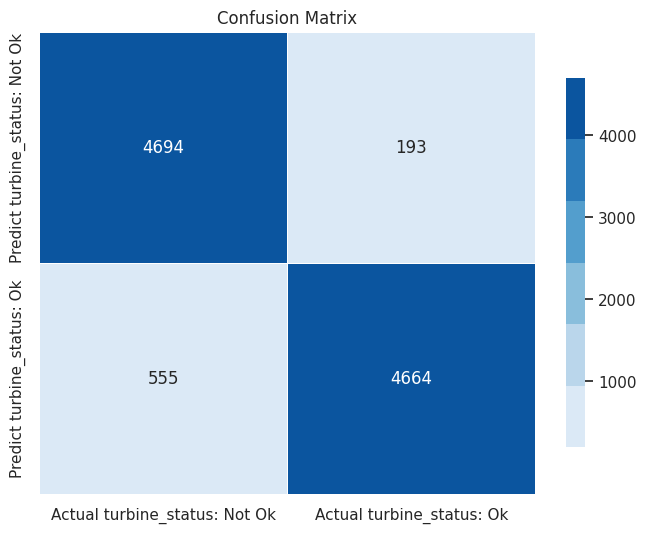

kernel = rbf
Model accuracy score with rbf kernel: 0.9900059370670888
Confusion matrix

 [[4817   70]
 [  31 5188]]

(turbine_status):1 / (turbine_status):1  =  4817

(turbine_status):2 / (turbine_status):2  =  70

(turbine_status):3 / (turbine_status):3 =  70

(turbine_status):0 / (turbine_status):0 =  5188


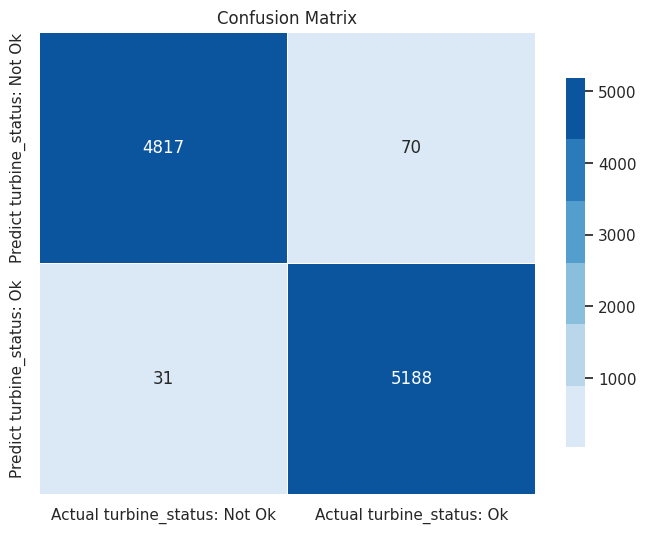

kernel = sigmoid
Model accuracy score with sigmoid kernel: 0.5966752424302395
Confusion matrix

 [[2853 2034]
 [2042 3177]]

(turbine_status):1 / (turbine_status):1  =  2853

(turbine_status):2 / (turbine_status):2  =  2034

(turbine_status):3 / (turbine_status):3 =  2034

(turbine_status):0 / (turbine_status):0 =  3177


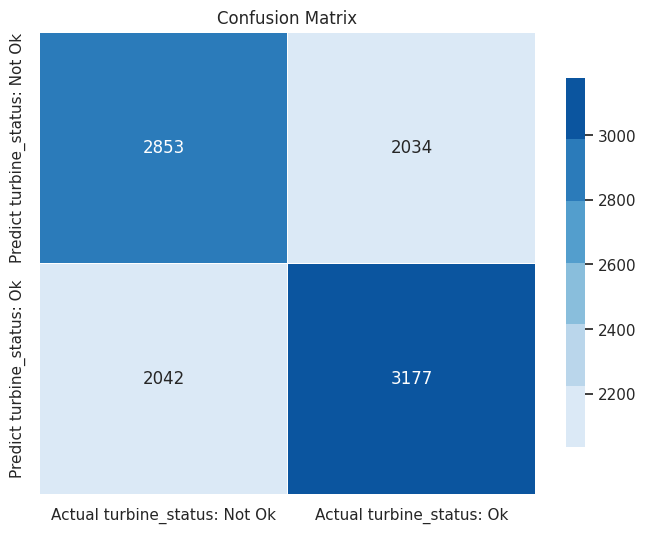

In [14]:
# List of kernels to loop through
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Loop over each kernel
for kernel in kernels:
    # instantiate classifier with the specified kernel
    svc = SVC(kernel=kernel)

    # fit classifier to training set
    svc.fit(X_train, y_train)

    # make predictions on test set
    y_pred = svc.predict(X_test)

    # compute and print accuracy score for each kernel
    accuracy = accuracy_score(y_test, y_pred)
    print(f'\033[1mkernel = {kernel}\033[0m')
    print(f'Model accuracy score with {kernel} kernel: {accuracy}')
    
    
    #### Confusion Matrix

    cm = confusion_matrix(y_test, y_pred)

    print('Confusion matrix\n\n', cm)

    print('\n(turbine_status):1 / (turbine_status):1  = ', cm[0,0])

    print('\n(turbine_status):2 / (turbine_status):2  = ', cm[0,1])

    print('\n(turbine_status):3 / (turbine_status):3 = ', cm[0,1])

    print('\n(turbine_status):0 / (turbine_status):0 = ', cm[1,1])



    #### Create graphical confusion matrix
    cm_matrix = pd.DataFrame(data=cm, 
                             columns=['Actual turbine_status: Not Ok', 'Actual turbine_status: Ok'], 
                             index=['Predict turbine_status: Not Ok', 'Predict turbine_status: Ok'])

    # Set a custom color palette
    colors = sns.color_palette("Blues")

    # Create a seaborn heatmap with a nicer theme
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.0)  # Adjust the font scale
    sns.set_style("whitegrid")  # Use a white grid background

    # Plot the heatmap
    heatmap = sns.heatmap(cm_matrix, annot=True, fmt='d', cmap=colors, linewidths=.5, cbar_kws={"shrink": 0.8})

    # Customize labels and title
    plt.title('Confusion Matrix')

    # Show the plot
    plt.show()    
    plt.rcdefaults()

# Results

## Logistic Regression

In [15]:
x = df2.drop(columns=["turbine_status"])
y = df2['turbine_status']

regressor = LogisticRegression()
regressor.fit(x, y)

y_pred = regressor.predict(x)

plotting_df = x.copy()
plotting_df.insert(len(x.columns),'y_test',y)
plotting_df.insert(len(x.columns),'y_pred',y_pred)
plotting_df

LV ActivePower (kW)  Wind Speed (m/s)  \
Date/Time                                                    
2018-01-01 00:00:00           380.047791          5.311336   
2018-01-01 00:10:00           453.769196          5.672167   
2018-01-01 00:20:00           306.376587          5.216037   
2018-01-01 00:30:00           419.645905          5.659674   
2018-01-01 00:40:00           380.650696          5.577941   
...                                  ...               ...   
2018-12-31 23:10:00          2963.980957         11.404030   
2018-12-31 23:20:00          1684.353027          7.332648   
2018-12-31 23:30:00          2201.106934          8.435358   
2018-12-31 23:40:00          2515.694092          9.421366   
2018-12-31 23:50:00          2820.466064          9.979332   

                     Theoretical_Power_Curve (KWh)  Wind Direction (°)  \
Date/Time                                                                
2018-01-01 00:00:00                     416.328908          259.994904   
2018-01-01 00:10:00                     519.917511          268.641113   
2018-01-01 00:20:00                     390.900016          272.564789   
2018-01-01 00:30:00                     516.127569          271.258087   
2018-01-01 00:40:00                     491.702972          265.674286   
...                                            ...                 ...   
2018-12-31 23:10:00                    3397.190793           80.502724   
2018-12-31 23:20:00                    1173.055771           84.062599   
2018-12-31 23:30:00                    1788.284755           84.742500   
2018-12-31 23:40:00                    2418.382503           84.297913   
2018-12-31 23:50:00                    2779.184096           82.274620   

                     power_deficit_percentage  y_pred  y_test  
Date/Time                                                      
2018-01-01 00:00:00                 -8.714532     0.0     1.0  
2018-01-01 00:10:00                -12.722848     0.0     0.0  
2018-01-01 00:20:00                -21.622774     0.0     0.0  
2018-01-01 00:30:00                -18.693375     0.0     0.0  
2018-01-01 00:40:00                -22.585236     0.0     0.0  
...                                       ...     ...     ...  
2018-12-31 23:10:00                -12.752002     0.0     0.0  
2018-12-31 23:20:00                 43.586782     1.0     0.0  
2018-12-31 23:30:00                 23.084812     1.0     0.0  
2018-12-31 23:40:00                  4.023829     1.0     1.0  
2018-12-31 23:50:00                  1.485399     1.0     1.0  

[50530 rows x 7 columns]

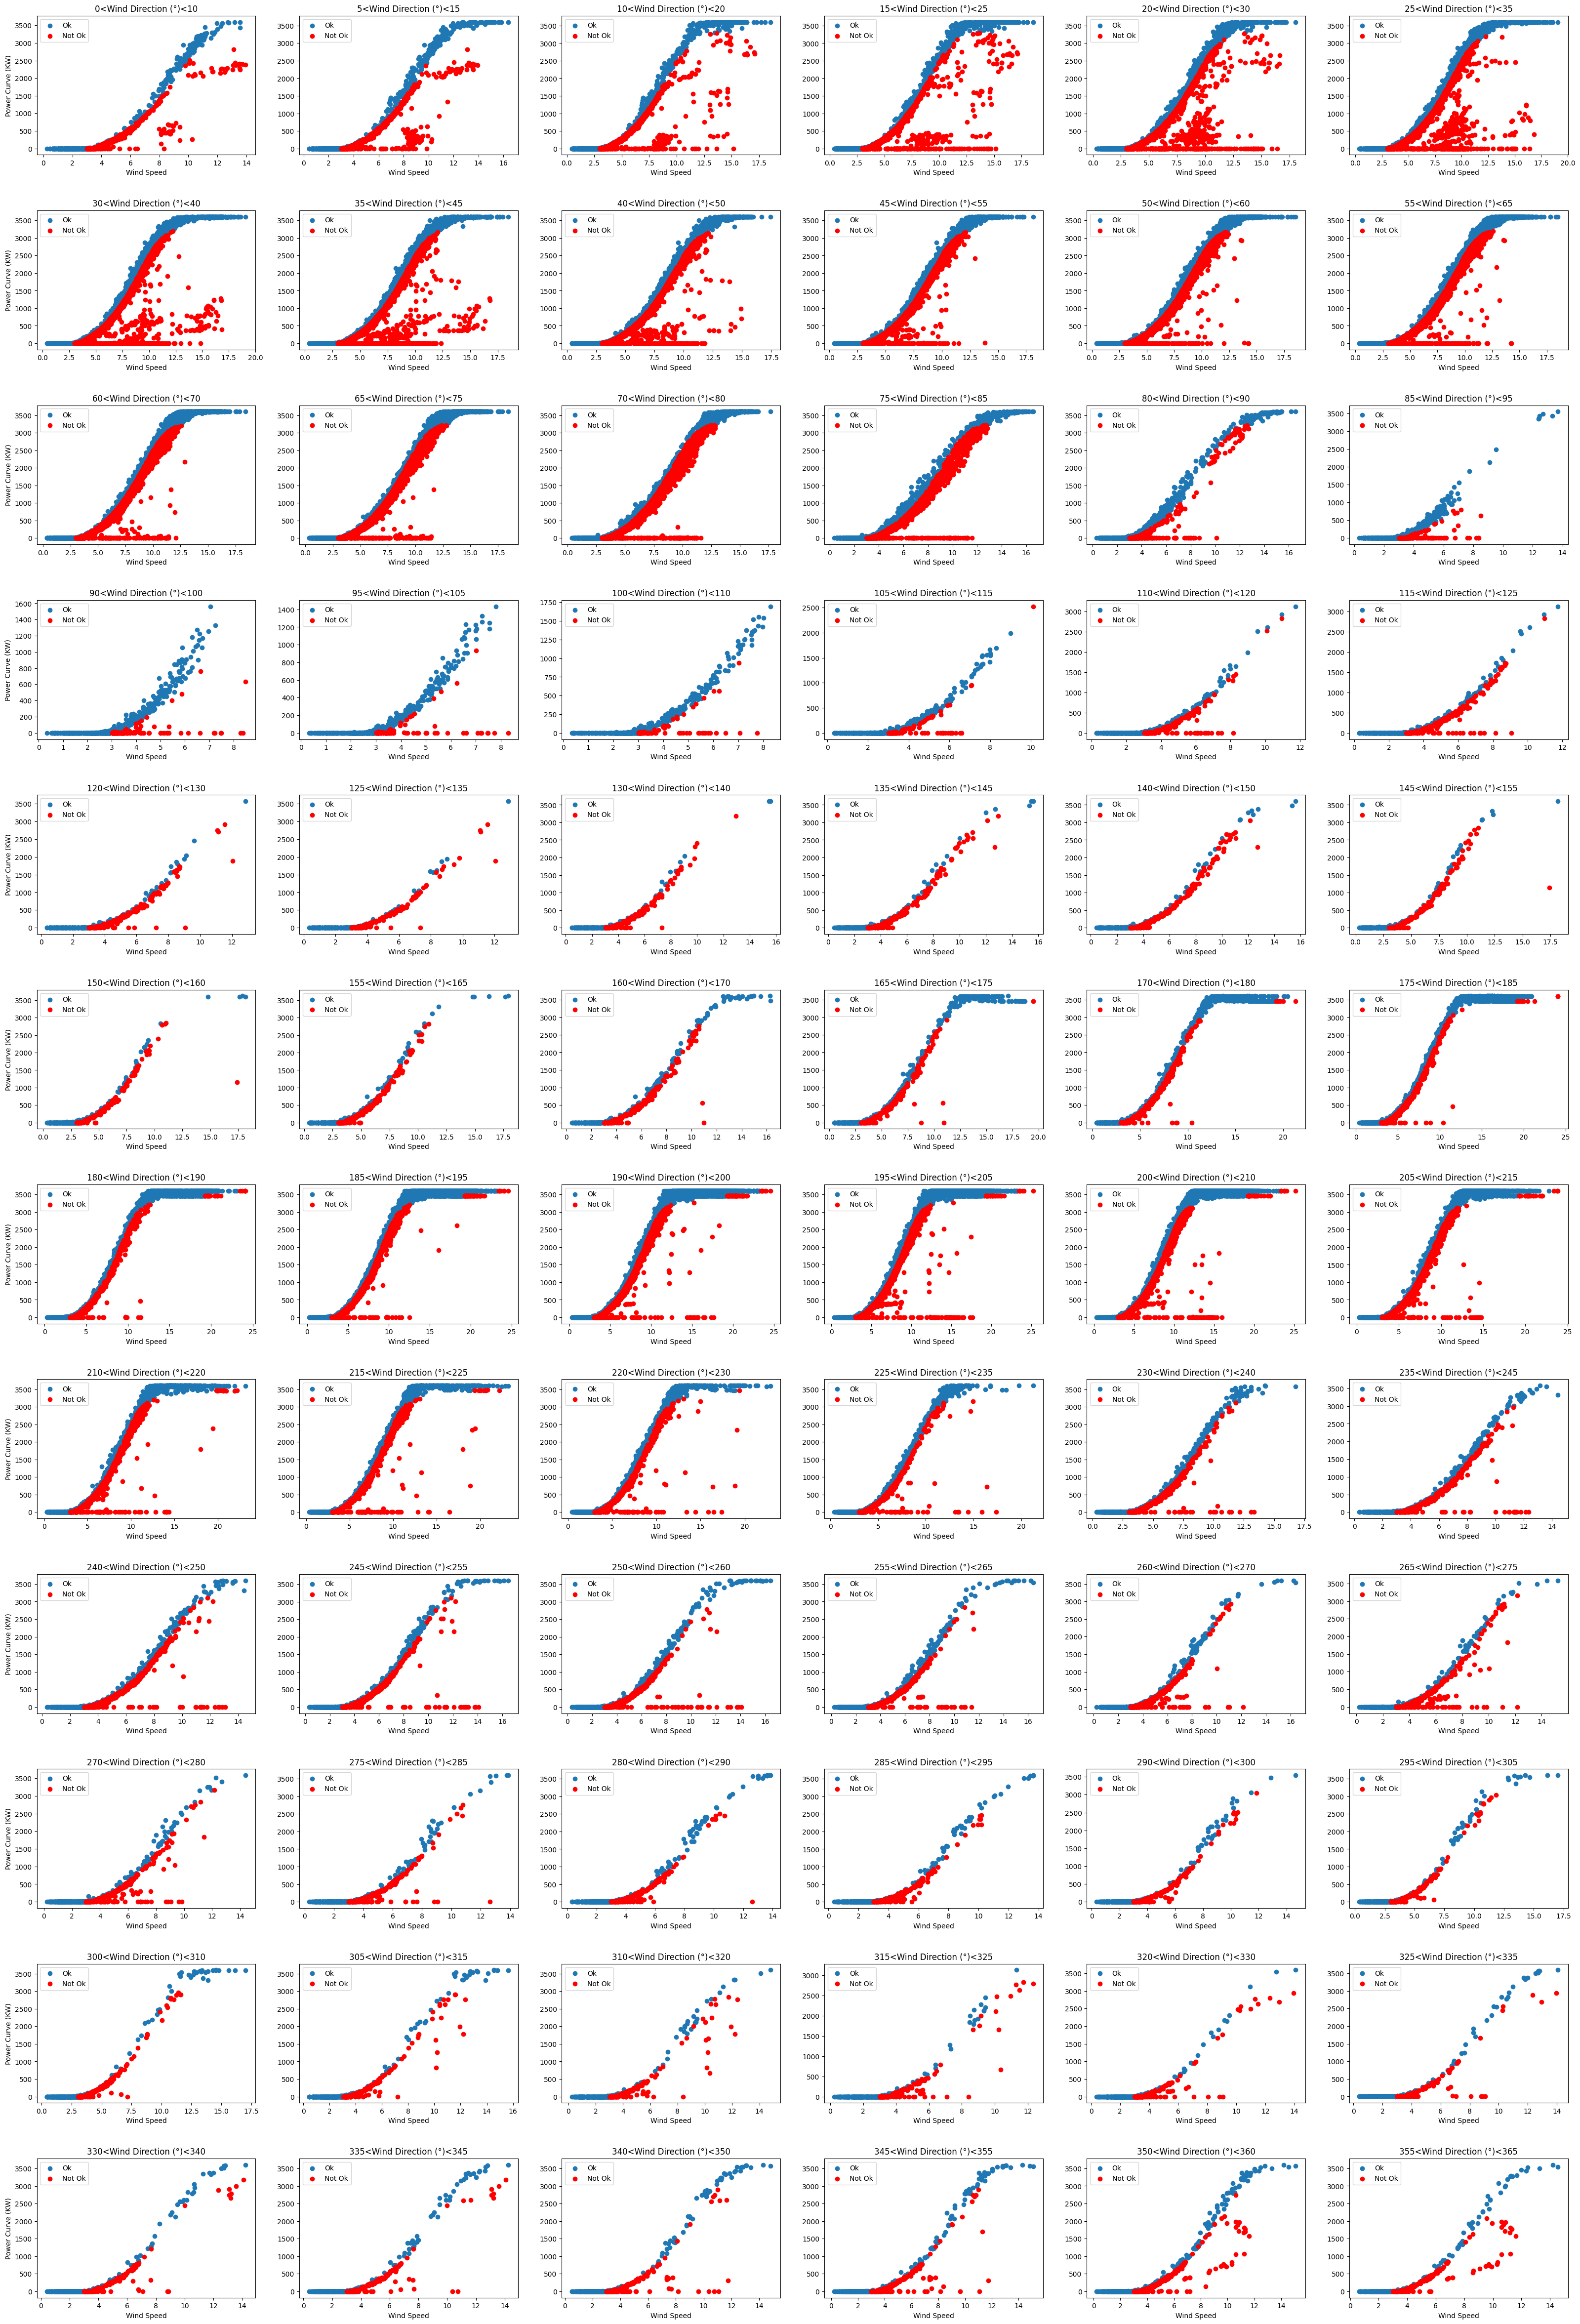

In [16]:
n = 0
plt.figure(figsize=(40,60))
for i in range(0,360,5):
    n += 1; fig = plt.subplot(12, 6, n)  # Subplot indexing starts from 1
    
    condition = (plotting_df['Wind Direction (°)']>i) & (plotting_df['Wind Direction (°)']<i+10) & (plotting_df['y_pred']==1)
    fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Ok')
    
    condition = (plotting_df['Wind Direction (°)']>i) & (plotting_df['Wind Direction (°)']<i+10) & (plotting_df['y_pred']==0)
    fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Not Ok',color='red')
    
    
    fig.set_title(f'{i}<Wind Direction (°)<{(i+10)}')
    plt.legend()
    
    
    fig.set_xlabel('Wind Speed')
    plt.subplots_adjust(hspace=0.4)
    if i%30 == 0:
        fig.set_ylabel('Power Curve (KW)')
plt.show()

## SVM

kernel = linear


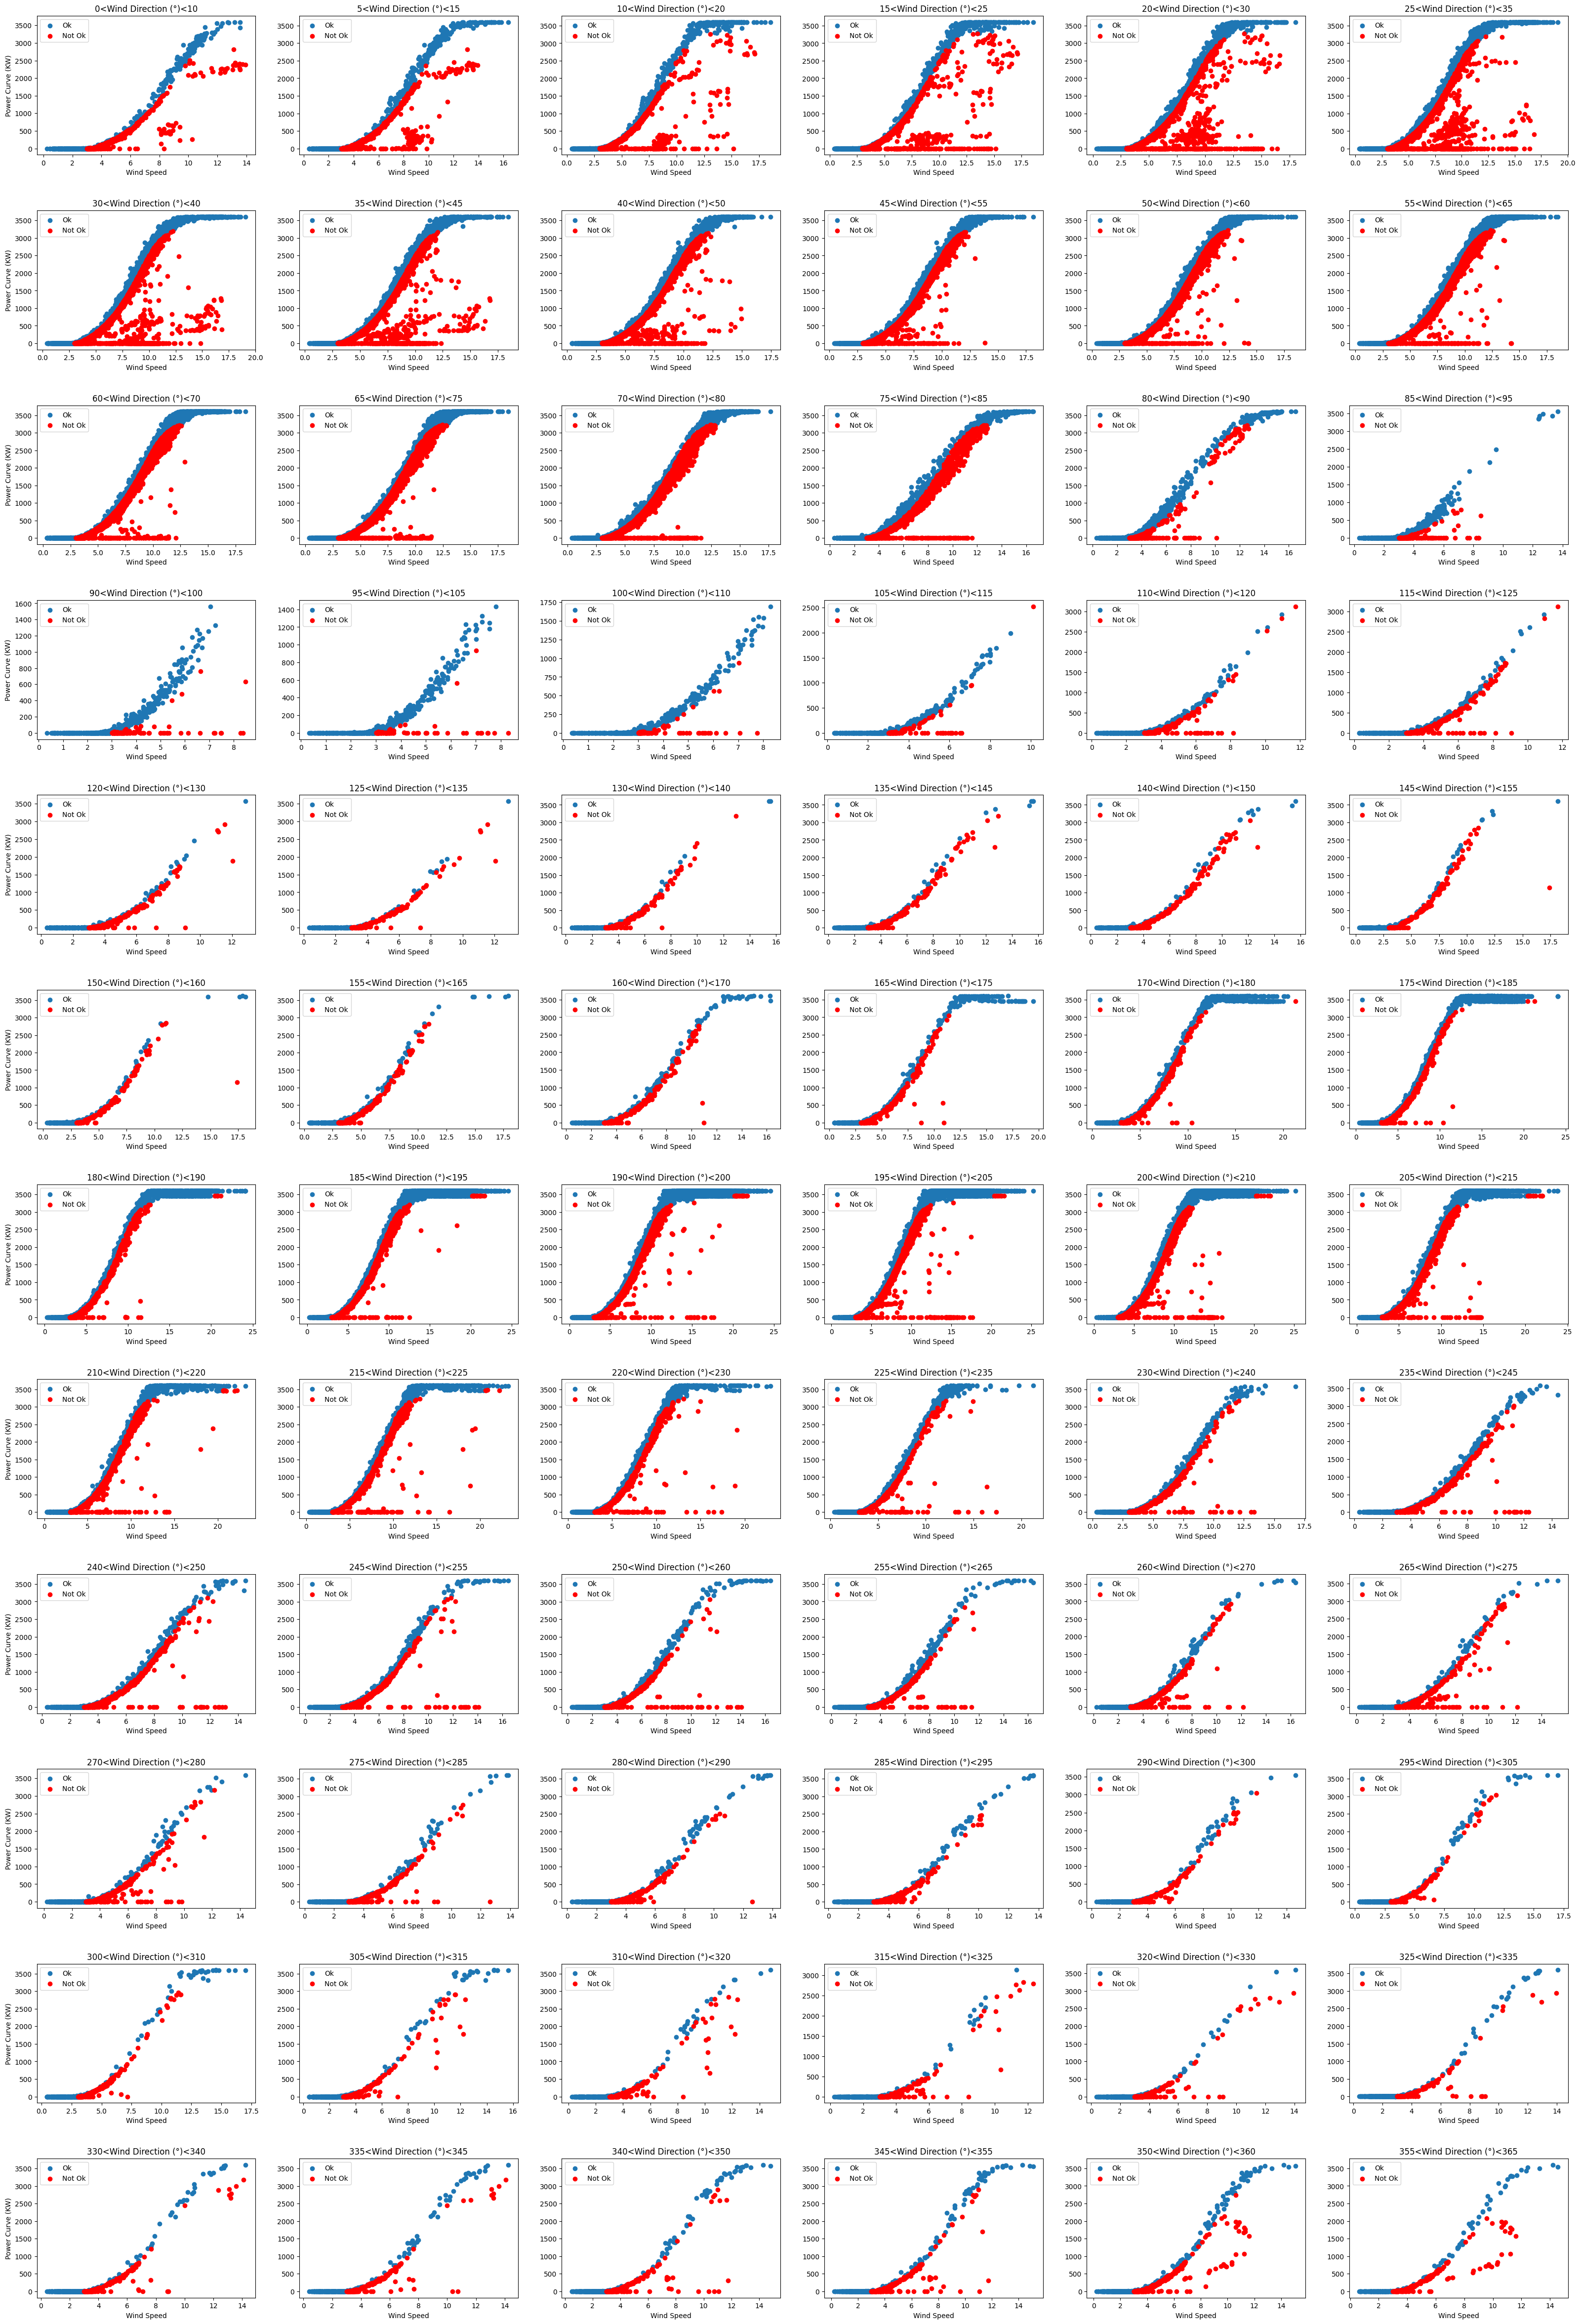

kernel = poly


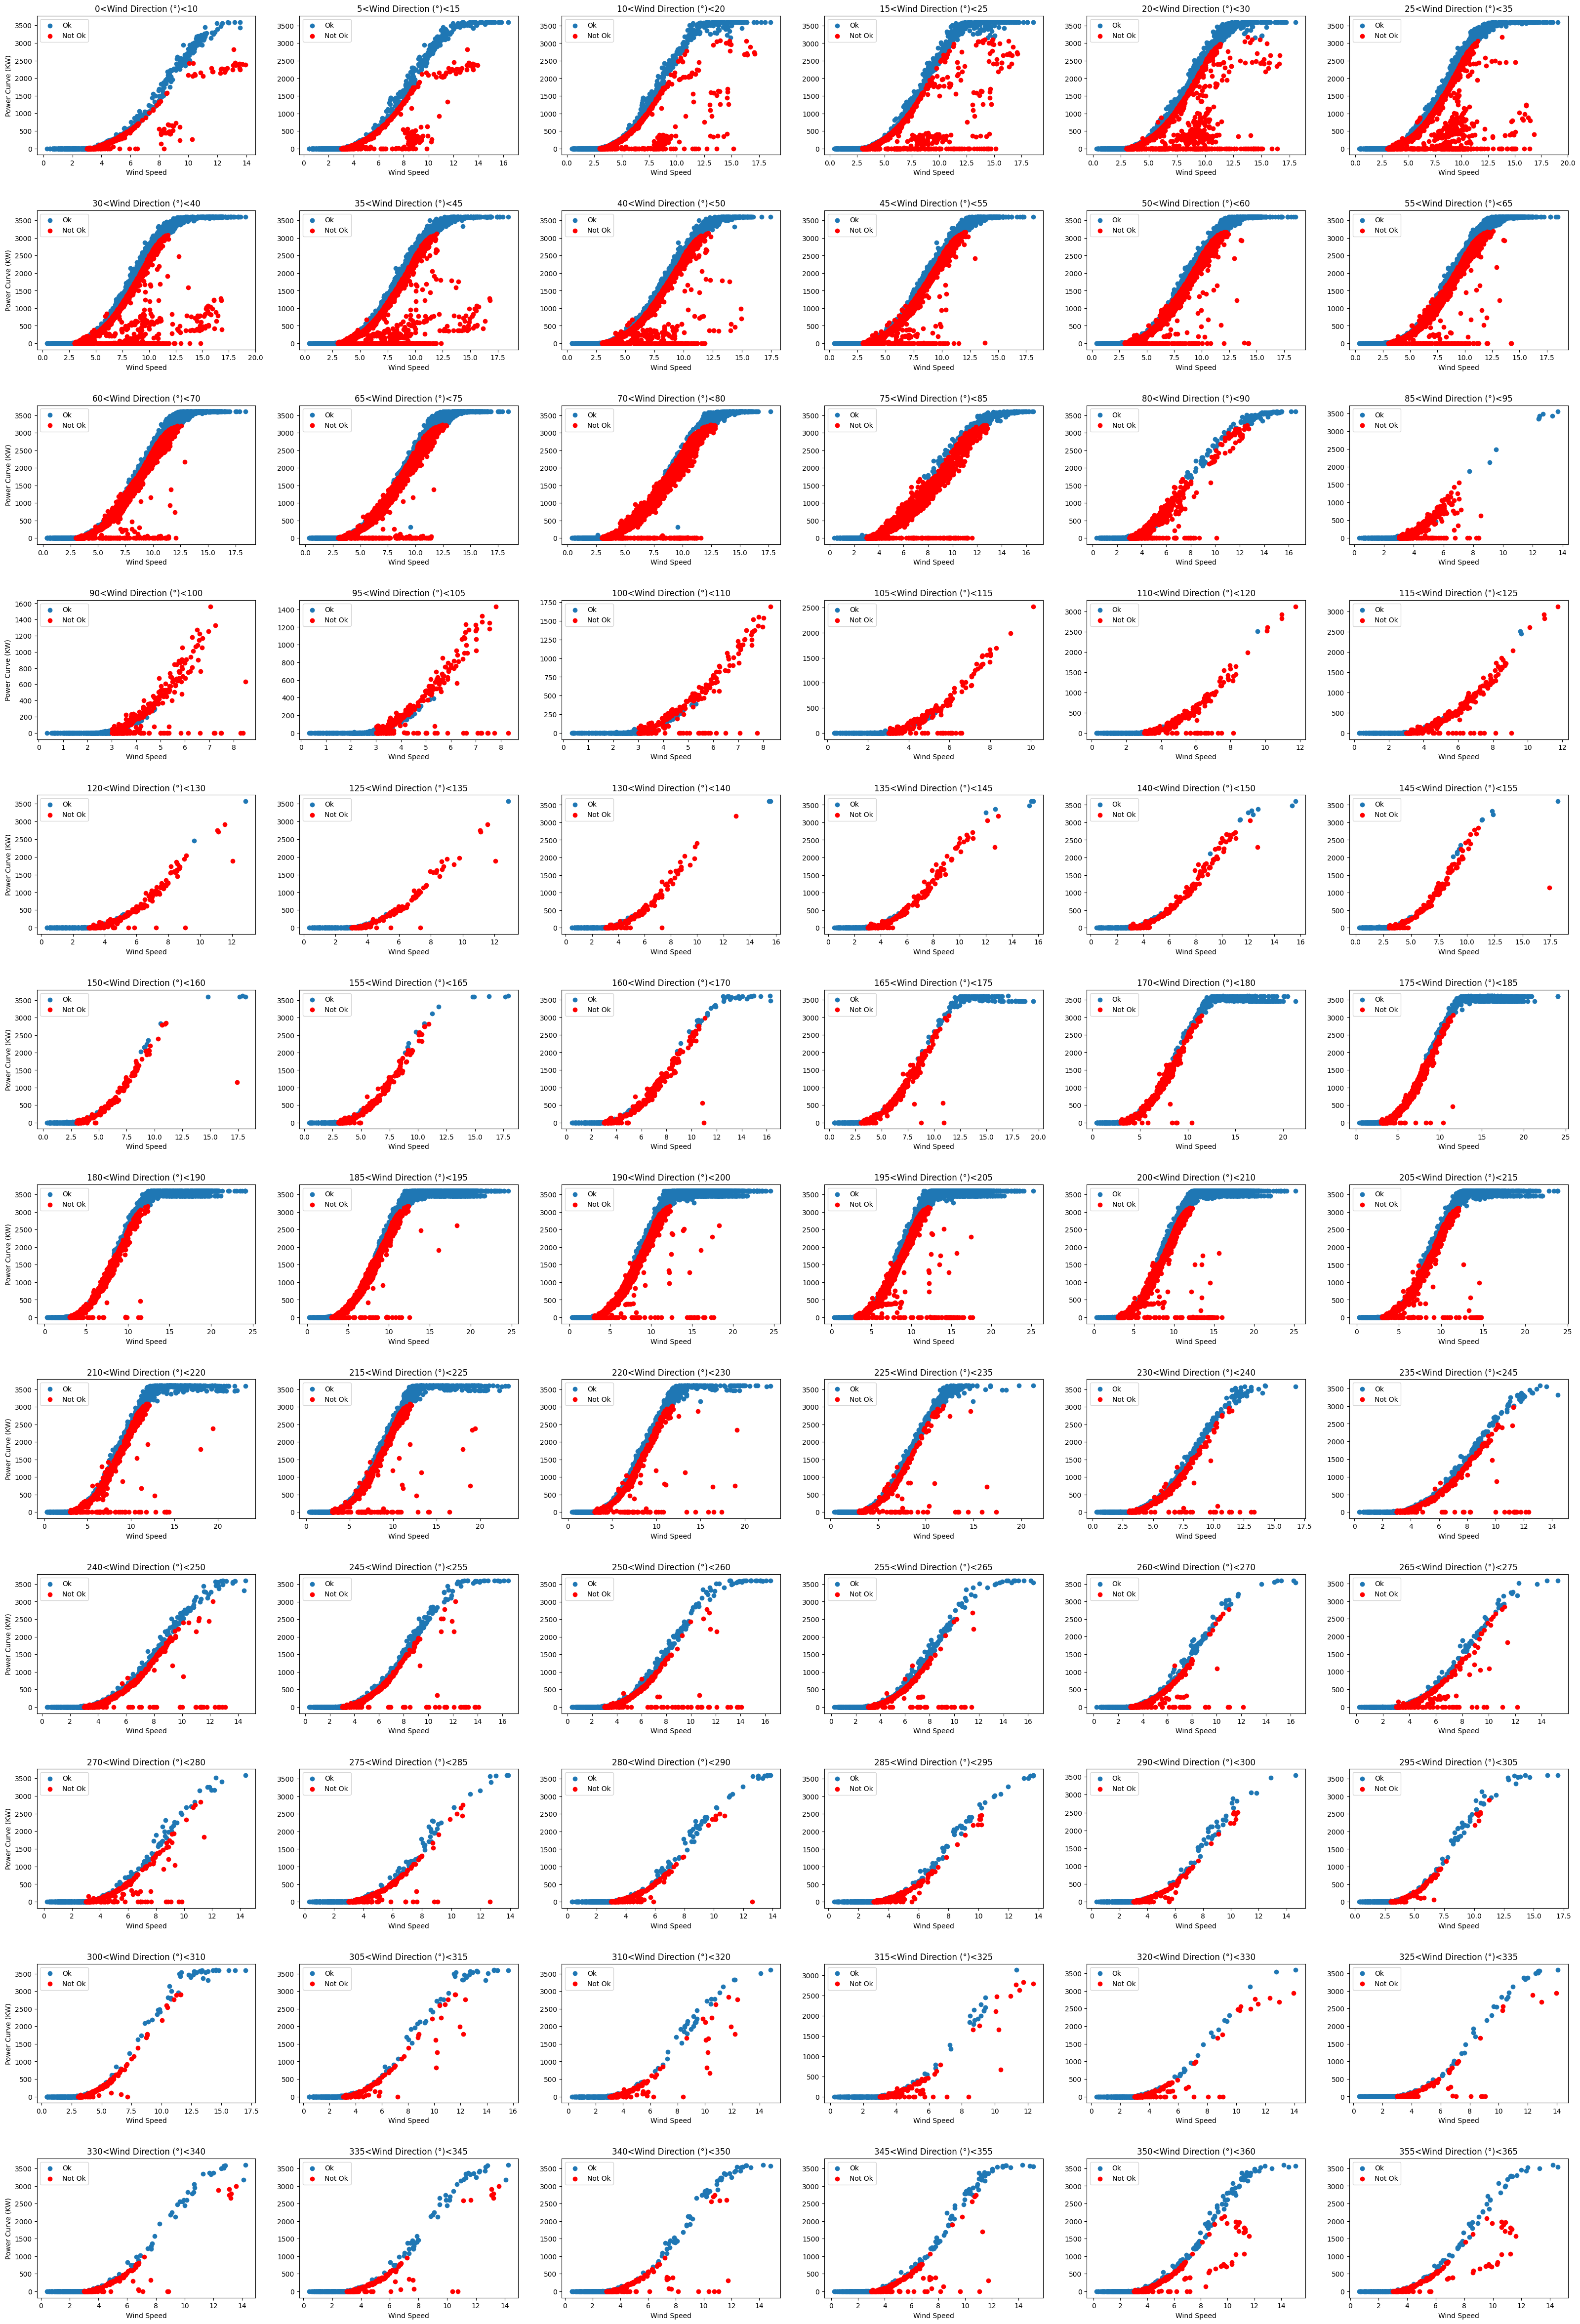

kernel = rbf


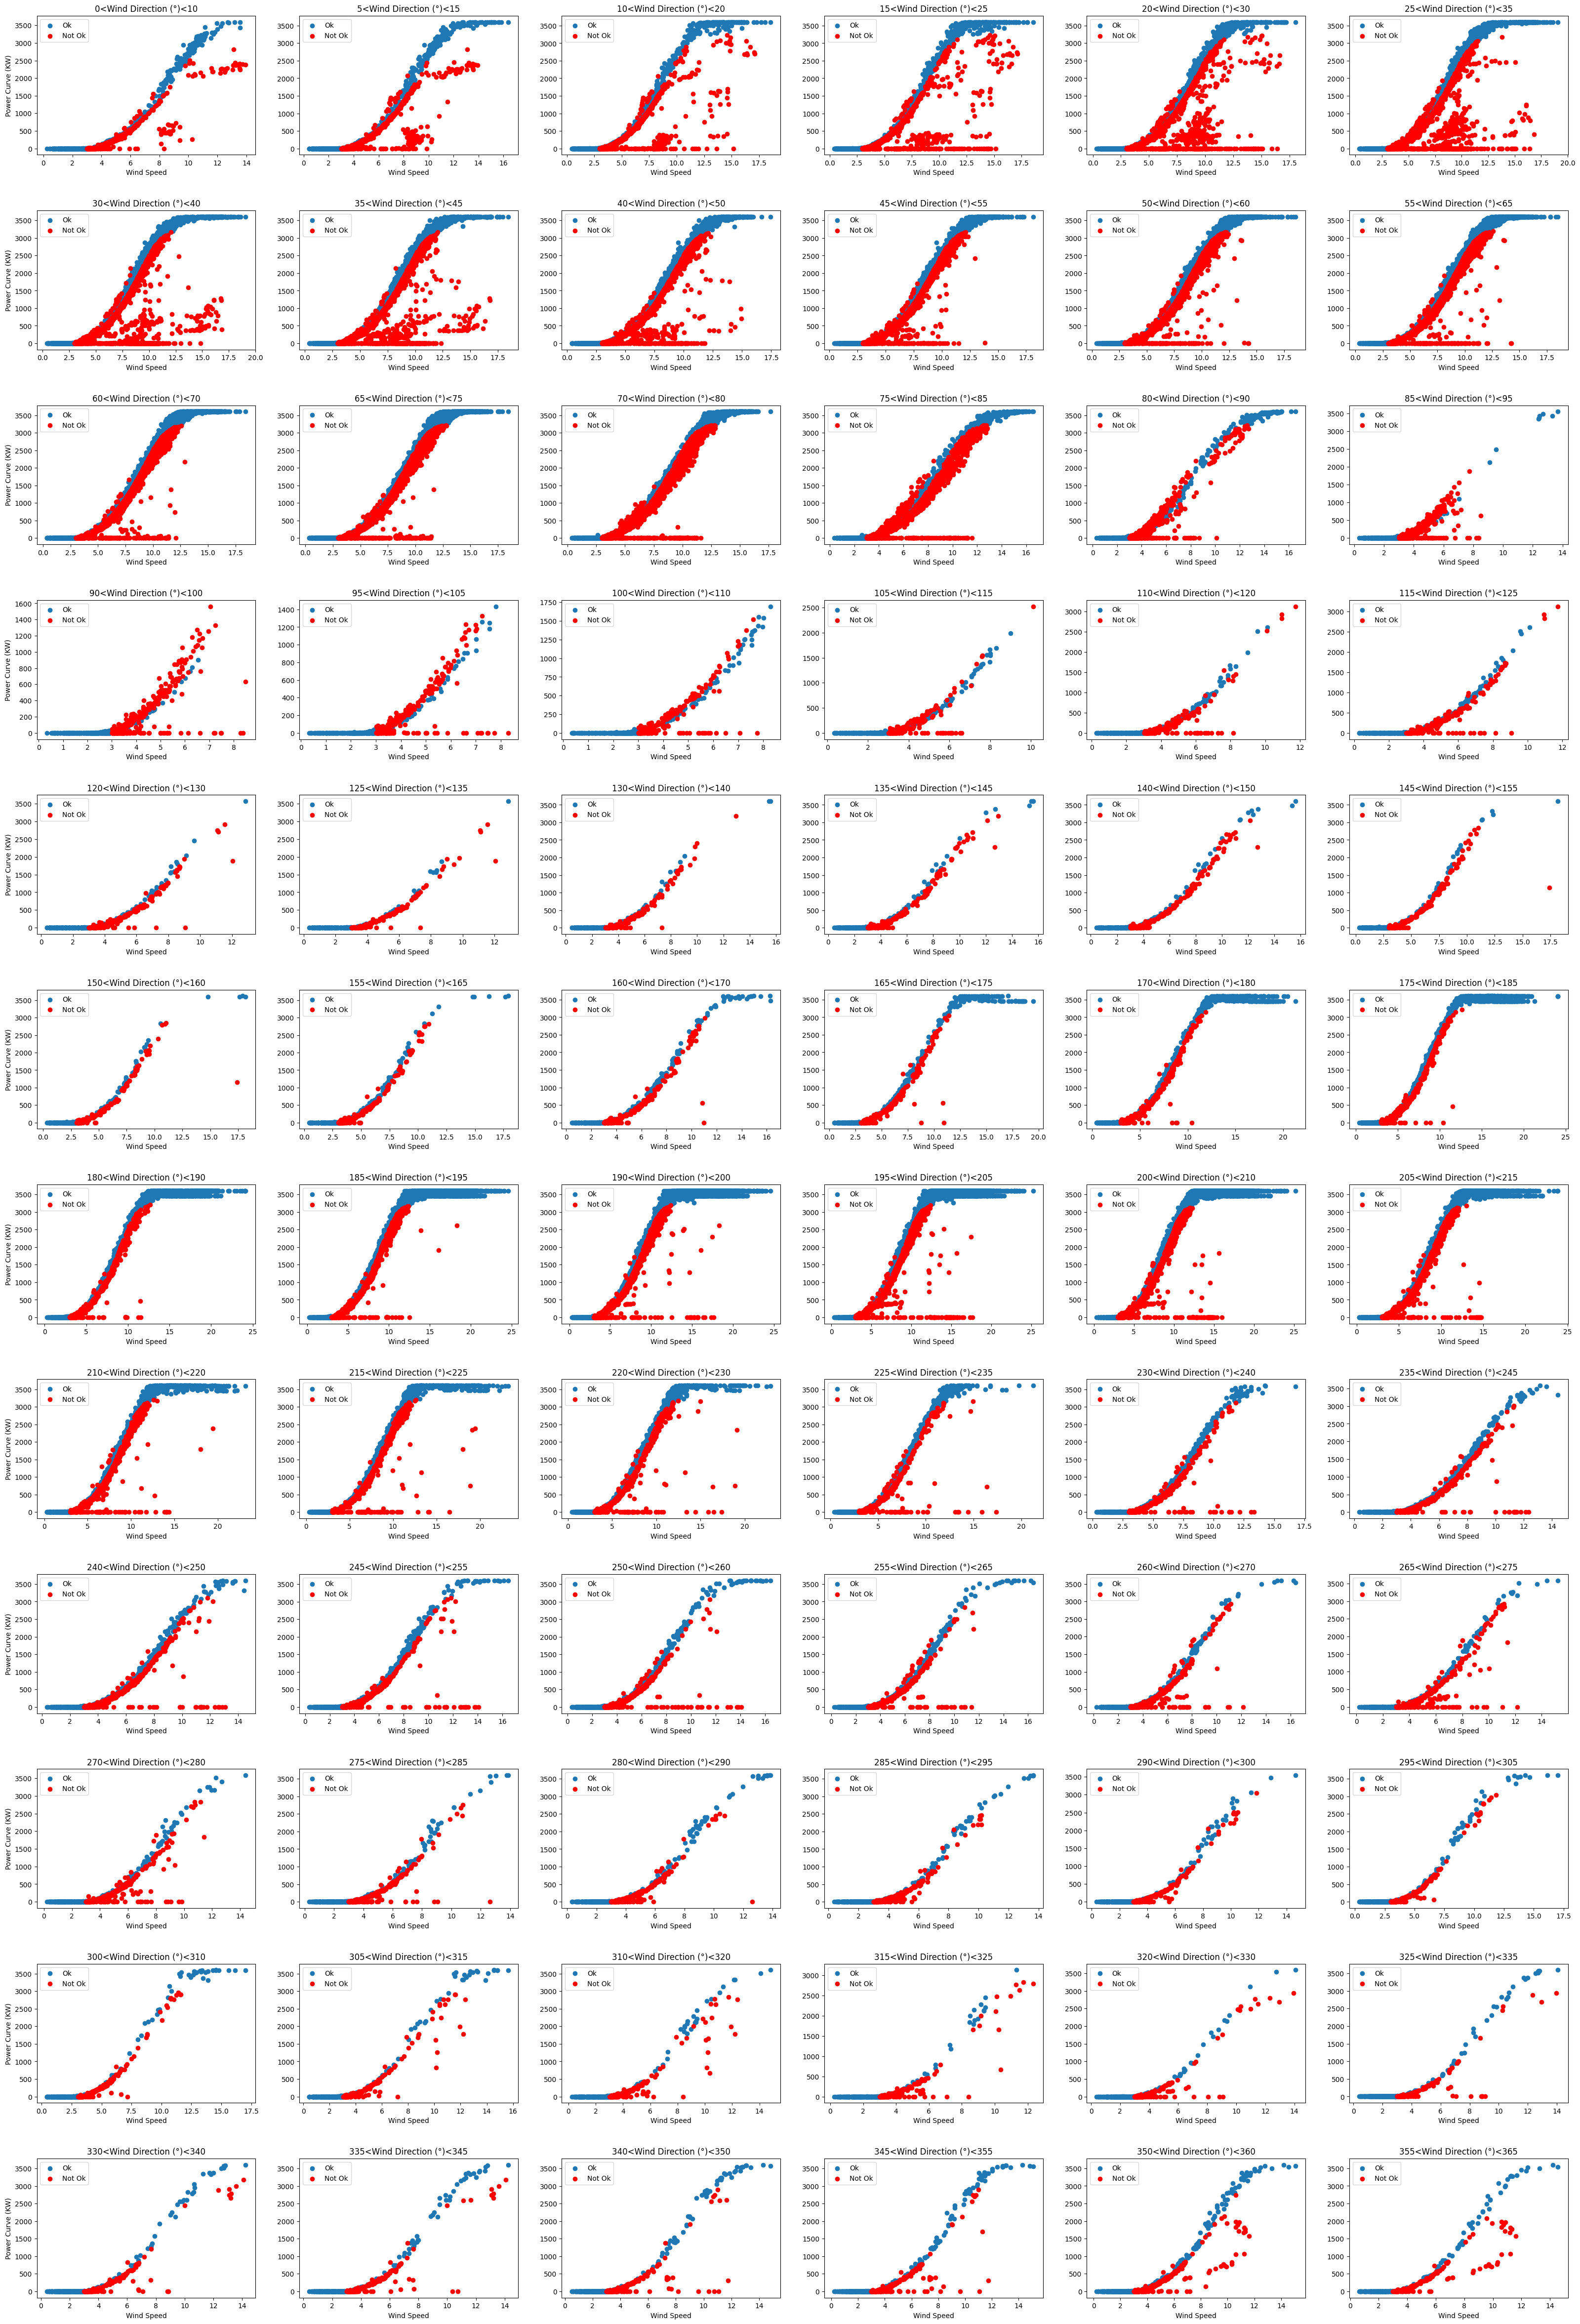

kernel = sigmoid


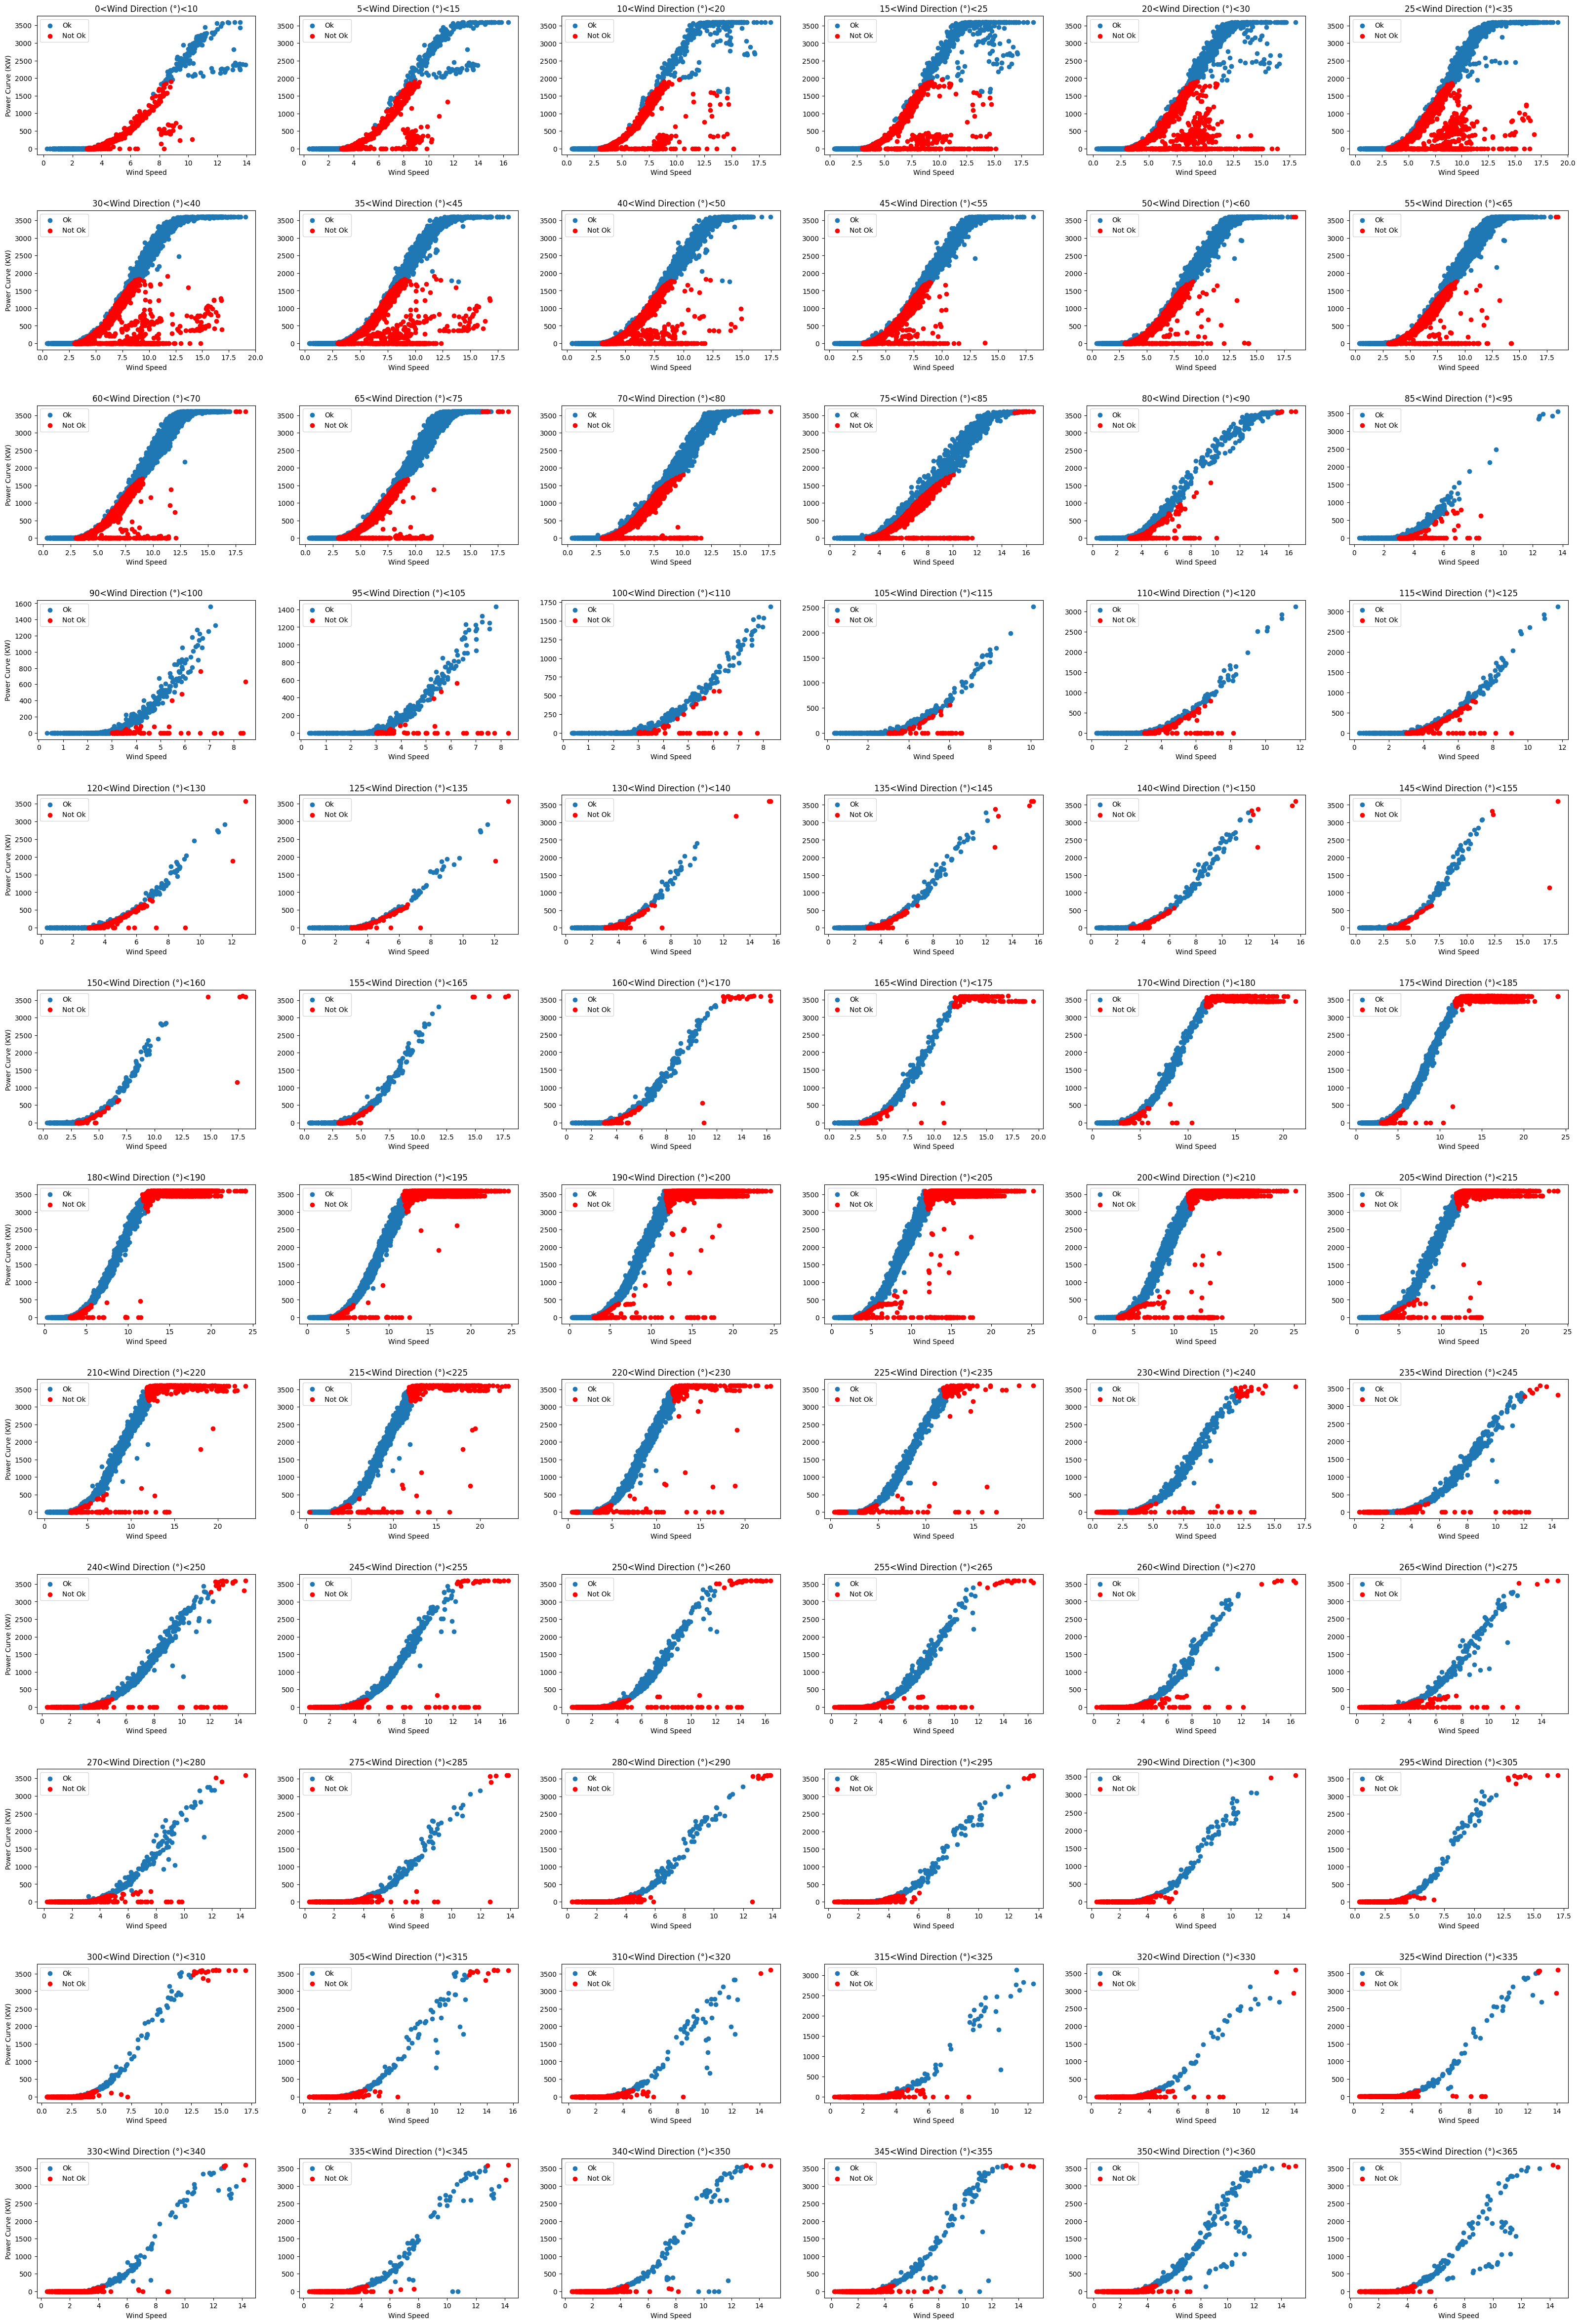

In [17]:
X = df2.drop(['turbine_status'], axis=1)
y = df2['turbine_status']

cols = X.columns
scaler = StandardScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=[cols])


# List of kernels to loop through
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Loop over each kernel
for kernel in kernels:
    # instantiate classifier with the specified kernel
    svc = SVC(kernel=kernel)

    # fit classifier to training set
    svc.fit(X, y)

    # make predictions on test set
    y_pred = svc.predict(X)

    # compute and plot score for each kernel
    print(f'\033[1mkernel = {kernel}\033[0m')

    
    plotting_df = x.copy()
    plotting_df.insert(len(x.columns),'y_test',y)
    plotting_df.insert(len(x.columns),'y_pred',y_pred)
    
    
    
    n = 0
    plt.figure(figsize=(40,60))
    for i in range(0,360,5):
        n += 1; fig = plt.subplot(12, 6, n)  # Subplot indexing starts from 1

        condition = (plotting_df['Wind Direction (°)']>i) & (plotting_df['Wind Direction (°)']<i+10) & (plotting_df['y_pred']==1)
        fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Ok')

        condition = (plotting_df['Wind Direction (°)']>i) & (plotting_df['Wind Direction (°)']<i+10) & (plotting_df['y_pred']==0)
        fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Not Ok',color='red')


        fig.set_title(f'{i}<Wind Direction (°)<{(i+10)}')
        plt.legend()


        fig.set_xlabel('Wind Speed')
        plt.subplots_adjust(hspace=0.4)
        if i%30 == 0:
            fig.set_ylabel('Power Curve (KW)')
    plt.show()

kernel = linear


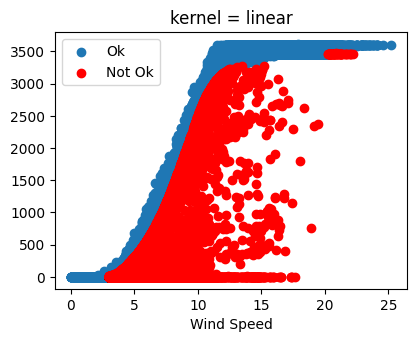

kernel = poly


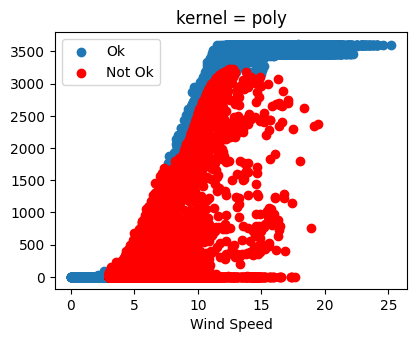

kernel = rbf


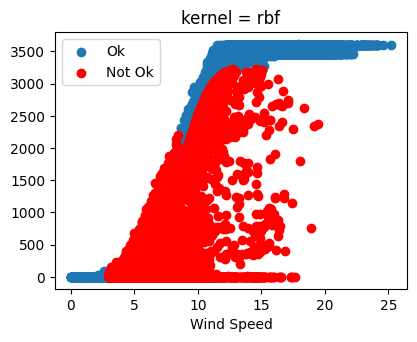

kernel = sigmoid


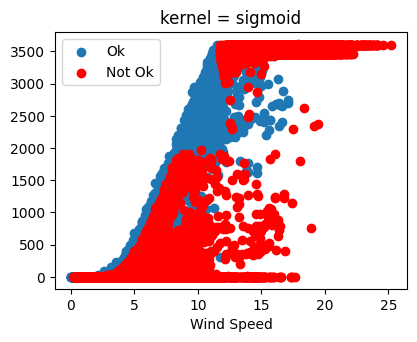

In [18]:
X = df2.drop(['turbine_status'], axis=1)
y = df2['turbine_status']

cols = X.columns
scaler = StandardScaler()

X = scaler.fit_transform(X)
X = pd.DataFrame(X, columns=[cols])


# List of kernels to loop through
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Loop over each kernel
n = 0
for kernel in kernels:
    # instantiate classifier with the specified kernel
    svc = SVC(kernel=kernel)

    # fit classifier to training set
    svc.fit(X, y)

    # make predictions on test set
    y_pred = svc.predict(X)

    # compute and plot for each kernel
    print(f'\033[1mkernel = {kernel}\033[0m')

    
    plotting_df = x.copy()
    plotting_df.insert(len(x.columns),'y_test',y)
    plotting_df.insert(len(x.columns),'y_pred',y_pred)
    
    plt.figure(figsize=(10,8))
    n += 1; fig = plt.subplot(2, 2, n)  # Subplot indexing starts from 1

    condition = (plotting_df['y_pred']==1)
    fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Ok')

    condition = (plotting_df['y_pred']==0)
    fig.scatter(plotting_df.loc[condition,'Wind Speed (m/s)'],plotting_df.loc[condition,'LV ActivePower (kW)'],label='Not Ok',color='red')


    fig.set_title(f'kernel = {kernel}')
    plt.legend()


    fig.set_xlabel('Wind Speed')
    plt.subplots_adjust(hspace=0.4)
    if i%30 == 0:
        fig.set_ylabel('Power Curve (KW)')
    plt.show()